In [2]:
import torch as th
import torch.nn as nn
import numpy as np
import scipy.io as sp
from functools import partial
from pyDOE import lhs

iter = 0
MU = 0.01
RHO = 1.0

In [4]:
def set_seed(seed: int = 42):
    '''
    Seeding the random variables for reproducibility
    ''' 
    th.manual_seed(seed)
    th.cuda.manual_seed(seed)
    th.cuda.manual_seed_all(seed)
    th.backends.cudnn.deterministic = True
    th.backends.cudnn.benchmark = False

In [5]:
class NSNN(nn.Module):
    def __init__(self,):
        # Input layer
        super(NSNN, self).__init__()
        self.linear_in = nn.Linear(2, 100)
        # Output layer
        self.linear_out = nn.Linear(100, 2)
        # Hidden Layers
        self.layers = nn.ModuleList(
            [ nn.Linear(100, 100) for i in range(3) ]
        )
        # Activation function
        self.act = nn.Tanh()

    def forward(self, x: th.Tensor) -> th.Tensor:
        x = self.linear_in(x)
        for layer in self.layers:
            x = self.act(layer(x))
        x = self.linear_out(x)
        return x

In [6]:
def derivative(dy: th.Tensor, x: th.Tensor, order: int = 1) -> th.Tensor:
    """
    This function calculates the derivative of the model at x_f
    """
    for i in range(order):
        dy = th.autograd.grad(
            dy, x, grad_outputs = th.ones_like(dy), create_graph=True, retain_graph=True
        )[0]
    return dy

In [ ]:
def f(model, x_f, y_f, t_f):
    """
    This function evaluates the PDE at collocation points.
    """
    hidden = model(th.stack((x_f, y_f, t_f), axis = -1))
    psi = hidden[:, 0]
    # predictions
    p = hidden[:, 1]
    u = derivative(psi, y_f, order=1)
    v = -derivative(psi, x_f, order=1)
    
    # first order derivatives
    u_x = derivative(u, x_f, order=1)
    u_y = derivative(u, y_f, order=1)
    u_t = derivative(u, t_f, order=1)
    
    v_x = derivative(v, x_f, order=1)
    v_y = derivative(v, y_f, order=1)
    v_t = derivative(v, t_f, order=1)
    
    p_x = derivative(p, x_f, order=1)
    p_y = derivative(p, y_f, order=1)
    
    # second order derivatives
    u_xx = derivative(u, x_f, order=2)
    u_yy = derivative(u, y_f, order=2)
    
    v_xx = derivative(v, x_f, order=2)
    v_yy = derivative(v, y_f, order=2)
    
    # PDEs
    f_u =  u_t + u*u_x + v*u_y + p_x - MU*(u_xx + u_yy) / RHO
    f_v =  v_t + u*v_x + v*v_y + p_y - MU*(v_xx + v_yy) / RHO
    f_uv = u_x + v_y

    return f_u, f_v, f_uv

def mse_f(model, x_f, y_f, t_f):
    """
    This function calculates the MSE for the PDE.
    """
    f_u, f_v, f_uv = f(model, x_f, y_f, t_f)
    return (f_u**2 + f_v**2 + f_uv**2).mean()

def mse_0(model, x_0, y_0):
    """
    This function calculates the MSE for the initial condition.
    """
    # creating a t_0 variable to be the same shape as the x_0 but with zero values
    t_0 = th.zeros_like(x_0)
    hidden = model(th.stack((x_0, y_0, t_0), axis = -1))
    # extracting the u and v values from the model output
    psi = hidden[:, 0]
    
    # predictions
    p_0 = hidden[:, 1]
    u_0 = derivative(psi, y_0, order=1)
    v_0 = -derivative(psi, x_0, order=1)
    return (p_0**2 + u_0**2 + v_0**2).mean()

def mse_b(model, t_b):
    """
    This function calculates the MSE for the boundary condition.
    """
    # x_b is the boundary points which have to be between -5 and 5
    x_b_left = th.zeros_like(t_b)-5
    x_b_left.requires_grad = True
    hidden = model(th.stack((x_b, y_b, t_b), axis = -1))
    # extracting the u and v values from the model output
    psi = hidden[:, 0]
    
    # predictions
    p_b = hidden[:, 1]
    u_b = derivative(psi, y_b, order=1)
    v_b = -derivative(psi, x_b, order=1)
    return mse_total

def closure(model, optimizer, x_f, y_f, t_f, t_0, t):
    """
    The closure function to use L-BFGS optimization method.
    """
    optimizer.zero_grad()
    # evaluating the MSE for the PDE
    loss = mse_f(model, x_f, t_f) + mse_0(model, x_0, u_0, v_0) + mse_b(model, t)
    loss.backward(retain_graph=True)
    global iter
    iter += 1
    print(f" iteration: {iter}  loss: {loss.item()}")
    if iter%30==0:
        th.save(model.state_dict(), f'results/model_LBFGS_{iter}.pt')
    return loss

def train(model,  x_f, t_f, x_0, u_0, v_0, h_0, t):
    # Initialize the optimizer
    optimizer = th.optim.LBFGS(model.parameters(),
                                    lr=1,
                                    max_iter=50000,
                                    max_eval=50000,
                                    history_size=50,
                                    tolerance_grad=1e-05,
                                    tolerance_change=0.5 * np.finfo(float).eps,
                                    line_search_fn="strong_wolfe")

    # the optimizer.step requires the closure function to be a callable function without inputs
    # therefore we need to define a partial function and pass it to the optimizer
    closure_fn = partial(closure, model, optimizer, x_f, t_f, x_0, u_0, v_0, h_0, t)
    optimizer.step(closure_fn)

In [63]:
from pyDOE import lhs
import numpy as np
import matplotlib.pyplot as plt

x_range = [-4, 16]
y_range = [-4, 4]
t_range = [0, 10]

time_steps = 100 # time steps
N0 = 100 # initial condition points
N_b = 840 # boundary points
N_circle = 100 # circle points
N_f = 20_000 # collocation points

top_points = np.linspace(-4, 16, 300)
bottom_points = np.linspace(-4, 16, 300)
left_points = np.linspace(-4, 4, 120)
right_points = np.linspace(-4, 4, 120)

partial_points = {}
partial_points["top"] = np.asarray([[x, 4] for x in top_points])
partial_points["bottom"] = np.asarray([[x, -4] for x in bottom_points])
partial_points["left"] = np.asarray([[-4, y] for y in left_points])
partial_points["right"] = np.asarray([[16, y] for y in right_points])

# Circle points
theta = np.linspace(0, 2*np.pi, N_circle, endpoint=False)
x = 0.5 * np.cos(theta)
y = 0.5 * np.sin(theta)

circle_points = np.column_stack((x, y))

# time points
time_points = lhs(1, samples=time_steps) * (t_range[1] - t_range[0]) + t_range[0]
time_points = np.sort(time_points, axis=0)

partial_points = np.asarray(partial_points)

initial_condition_array = np.concatenate((partial_points, np.zeros((len(partial_points), 1))), axis=1)

boundary_condition_points = []
for t in time_points:
    points = np.concatenate((partial_points, np.full((len(partial_points), 1), t)), axis=1)
    boundary_condition_points.append(points)

boundary_condition_points = np.concatenate(boundary_condition_points, axis=0)

(84000, 3)

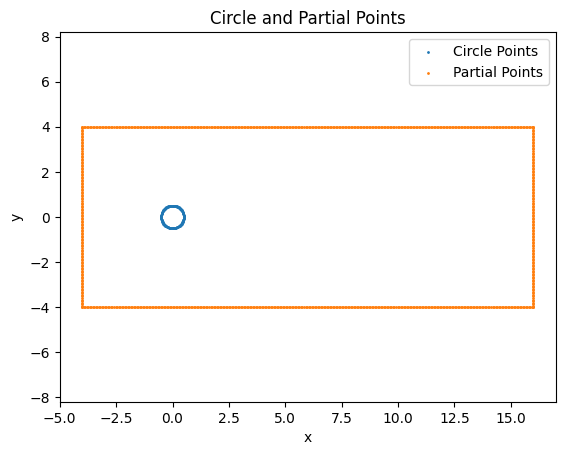

In [57]:
# plt.figure(figsize=(8, 8))  # Set the figure size to have equal width and height
plt.scatter(circle_points[:, 0], circle_points[:, 1], label='Circle Points', s=1)
plt.scatter(partial_points[:, 0], partial_points[:, 1], label='Partial Points', s=1)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Circle and Partial Points')
plt.legend()
plt.axis('equal')  # Set the x and y axis to have equal scaling
plt.show()

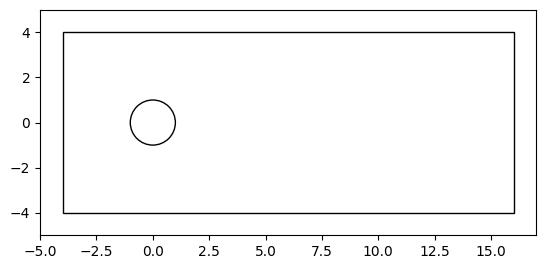

In [72]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

# Create a figure and axes
fig, ax = plt.subplots()

# Create a circle patch
# Create a rectangle patch

rectangle = plt.Rectangle((-4, -4), 20, 8, edgecolor='k', facecolor='none')
circle = Circle((0, 0), 1, edgecolor='k', facecolor='none')

ax.add_patch(rectangle)
ax.add_patch(circle)

# Set the aspect ratio of the axes to 'equal' to ensure the circle is circular
ax.set_aspect('equal')

# Set the limits of the axes
ax.set_xlim(-5, 17)
ax.set_ylim(-5, 5)

# Show the plot
plt.show()

In [ ]:
    # Upper and lower bounds of the spatial and temporal domains
    lb = np.array([-5.0, 0.0])
    ub = np.array([5.0, np.pi/2])
    # Number of initial, boundary and collocation points
    N0 = 50 # initial condition points
    N_b = 50 # boundary points
    N_f = 20_000 # collocation points
    # Loading the training points
    data = sp.loadmat('Schrodingers_Equation/data/NLS.mat')
    x_0 = th.from_numpy(data['x'].astype(np.float32))
    x_0.requires_grad = True
    x_0 = x_0.flatten().T

    t = torch.from_numpy(data['tt'].astype(np.float32))
    t.requires_grad = True
    t = t.flatten().T

    h = torch.from_numpy(data['uu'])

    # Slicing the initial value of h and saving it as u_0 and v_0
    u_0 = torch.real(h)[:, 0]
    v_0 = torch.imag(h) [:, 0]
    h_0 = torch.stack((u_0, v_0), axis = 1)

    # collocation data points using latin hypercube sampling method
    c_f = lb + (ub-lb)*lhs(2, N_f)
    x_f = torch.from_numpy(c_f[:, 0].astype(np.float32))
    x_f.requires_grad = True
    t_f = torch.from_numpy(c_f[:, 1].astype(np.float32))
    t_f.requires_grad = True

    # Sampling from the initial, boundary and collocation values
    # Sample N0 points from the initial value
    idx_0 = np.random.choice(x_0.shape[0], N0, replace = False)
    x_0 = x_0[idx_0]
    u_0 = u_0[idx_0]
    v_0 = v_0[idx_0]
    h_0 = h_0[idx_0]

    # # Sample Nb points from boundary values
    idx_b = np.random.choice(t.shape[0], N_b,replace = False )
    t_b = t[idx_b]

    # Instantiate the model
    model = SchrodingerNN()
    # Apply the initialization function to the model weights
    model.apply(init_weights)

    # Training the model
    model.train()
    train(model, x_f, t_f, x_0, u_0, v_0, h_0, t_b)
    torch.save(model.state_dict(), 'Schrodingers_Equation/models/model_LBFGS.pt')